In [1]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

import matplotlib.pyplot as plt
from matplotlib import animation

# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# from utils import io, abi, glm, nexrad
from utils import io, abi

In [2]:
goes_data_path = './data/GOES16'

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'

In [4]:
dates = [datetime(2018,6,19,16) + timedelta(hours=i) for i in range(4)]
abi_files = list(sum([sorted(io.find_abi_files(date, satellite=16, product='MCMIP', view='C', mode=3, 
                                        save_dir=goes_data_path, 
                                        replicate_path=True, check_download=True, 
                                        n_attempts=1, download_missing=True))
                  for date in dates],[]))
             

abi_files = {io.get_goes_date(i):i for i in abi_files}
abi_dates = list(abi_files.keys())
len(abi_files)


48

In [5]:
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files.values(), concat_dim='t', combine='nested').isel({'x':slice(1350,1500), 'y':slice(700,850)})

In [6]:
goes_ds

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 48, x: 150, y: 150)
Coordinates:
    band_id_C12                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C11                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C10                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C15                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C07                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C06                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C01                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C03                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C03                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C09                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C01                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C06                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C09                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C08                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C14                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C04                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C14                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C08                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C04                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C11                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C13                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C15                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C02                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    x_image                                 float32 -0.03136
    band_wavelength_C02                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_image                                 float32 0.08624
    band_wavelength_C12                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C10                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C13                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C16                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C05                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C16                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C07                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C05                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
  * y                                       (y) float32 0.089012004 ... 0.080668
  * x                                       (x) float32 -0.025732003 ... -0.0...
  * t                                       (t) datetime64[ns] 2018-06-19T16:...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables:
    CMI_C01                                 (t, y, x) float32 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    DQF_C01  

Text(0.5, 1.0, 'Ch16: "C02"')

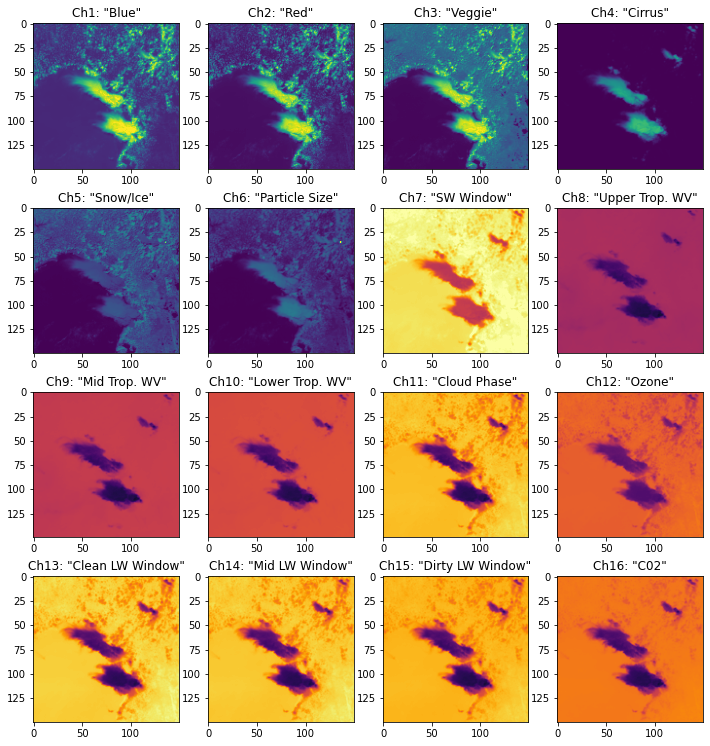

In [7]:
# Now plot all 16 channels
i = 24

fig, ax = plt.subplots(4,4, figsize=(12,13))
ax[0,0].imshow(goes_ds.CMI_C01[i], cmap='viridis', vmin=0, vmax=1)
ax[0,0].set_title('Ch1: "Blue"')

ax[0,1].imshow(goes_ds.CMI_C02[i], cmap='viridis', vmin=0, vmax=1)
ax[0,1].set_title('Ch2: "Red"')

ax[0,2].imshow(goes_ds.CMI_C03[i], cmap='viridis', vmin=0, vmax=1)
ax[0,2].set_title('Ch3: "Veggie"')

ax[0,3].imshow(goes_ds.CMI_C04[i], cmap='viridis', vmin=0, vmax=1)
ax[0,3].set_title('Ch4: "Cirrus"')

ax[1,0].imshow(goes_ds.CMI_C05[i], cmap='viridis', vmin=0, vmax=1)
ax[1,0].set_title('Ch5: "Snow/Ice"')

ax[1,1].imshow(goes_ds.CMI_C06[i], cmap='viridis', vmin=0, vmax=1)
ax[1,1].set_title('Ch6: "Particle Size"')

ax[1,2].imshow(goes_ds.CMI_C07[i], cmap='inferno', vmin=190, vmax=310)
ax[1,2].set_title('Ch7: "SW Window"')

ax[1,3].imshow(goes_ds.CMI_C08[i], cmap='inferno', vmin=190, vmax=310)
ax[1,3].set_title('Ch8: "Upper Trop. WV"')

ax[2,0].imshow(goes_ds.CMI_C09[i], cmap='inferno', vmin=190, vmax=310)
ax[2,0].set_title('Ch9: "Mid Trop. WV"')

ax[2,1].imshow(goes_ds.CMI_C10[i], cmap='inferno', vmin=190, vmax=310)
ax[2,1].set_title('Ch10: "Lower Trop. WV"')

ax[2,2].imshow(goes_ds.CMI_C11[i], cmap='inferno', vmin=190, vmax=310)
ax[2,2].set_title('Ch11: "Cloud Phase"')

ax[2,3].imshow(goes_ds.CMI_C12[i], cmap='inferno', vmin=190, vmax=310)
ax[2,3].set_title('Ch12: "Ozone"')

ax[3,0].imshow(goes_ds.CMI_C13[i], cmap='inferno', vmin=190, vmax=310)
ax[3,0].set_title('Ch13: "Clean LW Window"')

ax[3,1].imshow(goes_ds.CMI_C14[i], cmap='inferno', vmin=190, vmax=310)
ax[3,1].set_title('Ch14: "Mid LW Window"')

ax[3,2].imshow(goes_ds.CMI_C15[i], cmap='inferno', vmin=190, vmax=310)
ax[3,2].set_title('Ch15: "Dirty LW Window"')

ax[3,3].imshow(goes_ds.CMI_C16[i], cmap='inferno', vmin=190, vmax=310)
ax[3,3].set_title('Ch16: "C02"')


In [8]:
# Test preprocessed gridded radar/glm file
# Note: these files have been produced using ./scripts/process_nexrad.py
regrid_files = ['./data/regrid/regrid_20180619_160000.nc', 
                './data/regrid/regrid_20180619_170000.nc', 
                './data/regrid/regrid_20180619_180000.nc', 
                './data/regrid/regrid_20180619_190000.nc']
grid_ds = xr.open_mfdataset(regrid_files, concat_dim='t', combine='nested')

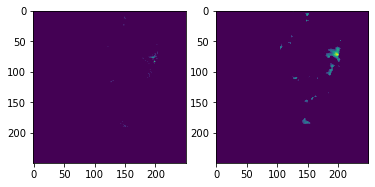

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(grid_ds.glm_freq[-1], vmin=0, vmax=5)
ax[1].imshow(ma.array(grid_ds.radar_ref[-1], mask=~grid_ds.radar_mask[-1]), vmin=0, vmax=40)

In [10]:
%%capture
fig, ax = plt.subplots(2,2,dpi=150, figsize=(7,6))

img_shape=grid_ds.glm_freq[0].shape
img00 = ax[0,0].imshow(np.zeros((*img_shape,3)))
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
img01 = ax[0,1].imshow(np.zeros(img_shape), vmin=180, vmax=320, cmap='inferno')
cbar01 = plt.colorbar(img01, ax=ax[0,1], label="Brightness temperature /K")
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
img10 = ax[1,0].imshow(np.zeros(img_shape), vmin=0, vmax=5)
cbar10 = plt.colorbar(img10, ax=ax[1,0], label="Flash frequency")
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
img11 = ax[1,1].imshow(np.zeros(img_shape), vmin=0, vmax=40)
cbar11 = plt.colorbar(img11, ax=ax[1,1], label="Radar reflectivity /dBz")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
t00 = ax[0,0].set_title('GOES-16 ABI RGB', loc='left', size=8)
t01 = ax[0,1].set_title('GOES-16 ABI C13', loc='left', size=8)
t10 = ax[1,0].set_title('GOES-16 GLM Flashes', loc='left', size=8)
t11 = ax[1,1].set_title('NEXRAD reflectivity', loc='left', size=8)

# init function: returns the plotting handles that will be modified
def init():
    img00.set_data(np.zeros((*img_shape,3)))
    img01.set_data(np.zeros(img_shape))
    img10.set_data(np.zeros(img_shape))
    img11.set_data(np.zeros(img_shape))
    return img00, img01, img10, img11

# animation function: modifies the data of the plot handles according to a frame index
def animate(i):
    rgbi = abi.get_abi_rgb(goes_ds.CMI_C01[i], goes_ds.CMI_C02[i], goes_ds.CMI_C03[i])
    img00.set_data(rgbi)
    img01.set_data(goes_ds.CMI_C13[i])
    img10.set_data(grid_ds.glm_freq[i])
    img11.set_data(ma.array(grid_ds.radar_ref[i], mask=~grid_ds.radar_mask[i]))
    return img00, img01, img10, img11

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=48, 
                               interval=100, repeat_delay=1000, blit=True)


In [ ]:
# Embed using ipython
from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())

In [8]:
# Now let's find the corresponding GLM files
glm_files = list(sum([sorted(io.find_glm_files(date, satellite=16,  
                                        save_dir=goes_data_path, 
                                        replicate_path=True, check_download=True, 
                                        n_attempts=1, download_missing=True))
                  for date in dates],[]))
             

glm_files = {io.get_goes_date(i):i for i in glm_files}
glm_dates = list(glm_files.keys())
len(glm_files)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


719

In [9]:
glm_files

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{datetime.datetime(2018, 6, 19, 16, 0): './data/GOES16/GLM-L2-LCFA/2018/170/16/OR_GLM-L2-LCFA_G16_s20181701600000_e20181701600200_c20181701600224.nc',
 datetime.datetime(2018, 6, 19, 16, 0, 20): './data/GOES16/GLM-L2-LCFA/2018/170/16/OR_GLM-L2-LCFA_G16_s20181701600200_e20181701600400_c20181701600423.nc',
 datetime.datetime(2018, 6, 19, 16, 0, 40): './data/GOES16/GLM-L2-LCFA/2018/170/16/OR_GLM-L2-LCFA_G16_s20181701600400_e20181701601000_c20181701601018.nc',
 datetime.datetime(2018, 6, 19, 16, 1): './data/GOES16/GLM-L2-LCFA/2018/170/16/OR_GLM-L2-LCFA_G16_s20181701601000_e20181701601200_c20181701601217.nc',
 datetime.datetime(2018, 6, 19, 16, 1, 20): './data/GOES16/GLM-L2-LCFA/2018/170/16/OR_GLM-L2-LCFA_G16_s20181701601200_e20181701601400_c20181701601415.nc',
 datetime.datetime(2018, 6, 19, 16, 1, 40): './data/GOES16/GLM-L2-LCFA/2018/170/16/OR_GLM-L2-LCFA_G16_s20181701601400_e20181701602000_c20181701602027.nc',
 datetime.datetime(2018, 6, 19, 16, 2): './data/GOES16/GLM-L2-LCFA/2018/170/16

In [10]:
from utils import glm

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
glm_ds = xr.open_dataset(list(glm_files.values())[0])

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def get_coord_bin_edges(coord):
    # Now set up the bin edges for the goes dataset coordinates. Note we multiply by height to convert into the Proj coords
    bins = np.zeros(coord.size+1)
    bins[:-1] += coord.data
    bins[1:] += coord.data
    bins[1:-1] /= 2
    return bins

def get_ds_bin_edges(ds, dims=None):
    if dims is None:
        dims = [coord for coord in ds.coords]
    elif isinstance(dims, str):
        dims = [dims]
    
    return [get_coord_bin_edges(ds.coords[dim]) for dim in dims]


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def get_corrected_glm_x_y(glm_filename):
    with xr.open_dataset(glm_filename) as glm_ds:
        lon_offset, lat_offset = glm.get_glm_parallax_offsets(glm_ds.flash_lon.data, glm_ds.flash_lat.data, goes_ds)
        glm_lon = glm_ds.flash_lon.data + lon_offset
        glm_lat = glm_ds.flash_lat.data + lat_offset
    return abi.get_abi_x_y(glm_lat, glm_lon, goes_ds)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
def get_uncorrected_glm_x_y(glm_filename):
    with xr.open_dataset(glm_filename) as glm_ds:
        return abi.get_abi_x_y(glm_ds.flash_lat.data, glm_ds.flash_lon.data, goes_ds)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def get_glm_hist(glm_files, goes_ds, start_time, end_time):
    x_bins, y_bins = get_ds_bin_edges(goes_ds, ('x','y'))
    glm_x, glm_y = (np.concatenate(locs) for locs in zip(*[get_corrected_glm_x_y(glm_files[i]) for i in glm_files 
          if i > start_time and i < end_time]))
    return np.histogram2d(glm_y, glm_x, bins=(y_bins[::-1], x_bins))[0][::-1]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
glm_da = xr.zeros_like(goes_ds.CMI_C13).compute()

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [137]:
xr.DataArray(np.zeros(goes_ds.CMI_C13.shape), goes_ds.CMI_C13.coords, goes_ds.CMI_C13.dims)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray (t: 48, y: 150, x: 150)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    x_image  float32 -0.03136
    y_image  float32 0.08624
  * x        (x) float32 -0.025732003 -0.025675997 ... -0.017444 -0.017388001
  * y        (y) float32 0.089012004 0.088956006 0.0889 ... 0.080724 0.080668
  * t        (t) datetime64[ns] 2018-06-19T16:03:43.239603968 ... 2018-06-19T...

In [17]:
for i, t in enumerate(glm_da.t):
    glm_da[i] = get_glm_hist(glm_files, goes_ds, abi_dates[i], abi_dates[i]+timedelta(minutes=5))

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
/Users/jonesw/python/example_notebooks/utils/glm.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/lmatools/coordinateSystems.py:89: DeprecationWarning: This function is deprecate

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


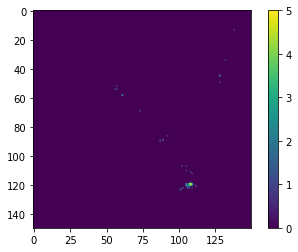

In [18]:
plt.imshow(glm_da[24])
plt.colorbar()

In [19]:
%%capture
fig = plt.figure(dpi=150, figsize=(6,6))

img_shape=glm_da[0].shape
img = plt.imshow(np.zeros(img_shape), vmin=0, vmax=5)
plt.xticks([])
plt.yticks([])
t1 = plt.title('GOES-16 GLM Flashes', loc='left', size=8)
t2 = plt.title('', loc='right', size=8)

# init function: returns the plotting handles that will be modified
def init():
    img.set_data(np.zeros(img_shape))
    t2.set_text('')
    return img, t2

# animation function: modifies the data of the plot handles according to a frame index
def animate(i):
    img.set_data(glm_da[i])
    t2.set_text(str(glm_da.t[i].data.astype('datetime64[s]'))+' UTC')
    return img, t2

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=48, 
                               interval=20, blit=True)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Embed using ipython
from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
from google.cloud import storage
nexrad_data_path = './data/nexrad_l2/'
if not os.path.isdir(nexrad_data_path):
    os.makedirs(nexrad_data_path)

def find_nexrad_blobs(date, site):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket('gcp-public-data-nexrad-l2')

    blob_path = '%04d/%02d/%02d/%s/' % (date.year, date.month, date.day, site)
    blob_prefix = 'NWS_NEXRAD_NXL2DPBL_%s_%04d%02d%02d%02d' % (site, date.year, date.month, date.day, date.hour)
    
    blobs = list(bucket.list_blobs(prefix=blob_path+blob_prefix, delimiter='/'))

    return blobs

def download_blobs(blob_list, save_dir='./', replicate_path=True,
                        n_attempts=0, clobber=False):
    for blob in blob_list:
        blob_path, blob_name = os.path.split(blob.name)

        if replicate_path:
            save_path = os.path.join(save_dir, blob_path)
        else:
            save_path = save_dir
        if not os.path.isdir(save_path):
            os.makedirs(save_path)

        save_file = os.path.join(save_path, blob_name)
        if clobber or not os.path.exists(save_file):
            blob.download_to_filename(save_file)
            
def find_nexrad_files(date, site, save_dir='./', replicate_path=True, download_missing=False):
    blobs = find_nexrad_blobs(date, site)
    files = []
    for blob in blobs:
        blob_path, blob_name = os.path.split(blob.name)

        if replicate_path:
            save_path = os.path.join(save_dir, blob_path)
        else:
            save_path = save_dir
        if not os.path.isdir(save_path):
            os.makedirs(save_path)

        save_file = os.path.join(save_path, blob_name)
        if os.path.exists(save_file):
            files += [save_file]
        elif download_missing:
            download_blobs([blob], save_dir=save_dir, replicate_path=replicate_path)
            if os.path.exists(save_file):
                files += [save_file]

    return files

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
find_nexrad_blobs(dates[0], 'KAMX')

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[<Blob: gcp-public-data-nexrad-l2, 2018/06/19/KAMX/NWS_NEXRAD_NXL2DPBL_KAMX_20180619160000_20180619165959.tar, 1529539534662504>]

In [23]:
find_nexrad_files(dates[0], 'KAMX', save_dir=nexrad_data_path, download_missing=True)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['./data/nexrad_l2/2018/06/19/KAMX/NWS_NEXRAD_NXL2DPBL_KAMX_20180619160000_20180619165959.tar']

In [24]:
# Pull out specific sites over Florida. There are a lot more sites covering the entire US (all site codes starting with 'K')
nexrad_sites = ['KTBW','KMLB','KAMX','KJAX','KVAX','KCLX','KTLH','KJGX','KEOX']
nexrad_files = sum([find_nexrad_files(date, site, save_dir=nexrad_data_path, download_missing=True) 
                    for date in dates for site in nexrad_sites], [])

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
len(nexrad_files)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


33

In [26]:
def get_gates_from_tar(nexrad_archive):
    time_list = []
    alt_list = []
    lat_list = []
    lon_list = []
    ref_list = []
    with tarfile.open(nexrad_archive) as tar:
        # Loop iver each element and inspect to see if they are actual radar archive files (there is also metadata in the tar)
        for item in [name for name in tar.getnames() if name[-9:] == '_V06.ar2v']:
            try:
                radar = pyart.io.read_nexrad_archive(tar.extractfile(tar.getmember(item)), 
                                                     include_fields=['reflectivity'],
                                                     delay_field_loading=True)
            except IOError:
                pass
            else:
                alt_list.append(radar.gate_altitude['data'])
                lat_list.append(radar.gate_latitude['data'])
                lon_list.append(radar.gate_longitude['data'])
                ref_list.append(radar.fields['reflectivity']['data'])
                
                start_time = parse_date(item[4:19], fuzzy=True)
                time_list.append([start_time+timedelta(seconds=t) for t in radar.time['data']])
                
    times = np.concatenate(time_list, 0)
    alts = np.concatenate(alt_list, 0)
    lats = np.concatenate(lat_list, 0)
    lons = np.concatenate(lon_list, 0)
    refs = np.concatenate(ref_list, 0)
    
    return times, alts, lats, lons, refs

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
radar_gates_0 = get_gates_from_tar(nexrad_files[0])

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
radar_gates_0

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([datetime.datetime(2018, 6, 19, 16, 0, 49, 910000),
        datetime.datetime(2018, 6, 19, 16, 0, 49, 938000),
        datetime.datetime(2018, 6, 19, 16, 0, 49, 963000), ...,
        datetime.datetime(2018, 6, 19, 17, 2, 58, 927000),
        datetime.datetime(2018, 6, 19, 17, 2, 58, 963000),
        datetime.datetime(2018, 6, 19, 17, 2, 58, 999000)], dtype=object),
 array([[5.1000e+01, 5.3000e+01, 5.5000e+01, ..., 1.5789e+04, 1.5805e+04,
         1.5820e+04],
        [5.1000e+01, 5.3000e+01, 5.5000e+01, ..., 1.5789e+04, 1.5805e+04,
         1.5820e+04],
        [5.1000e+01, 5.3000e+01, 5.5000e+01, ..., 1.5789e+04, 1.5805e+04,
         1.5820e+04],
        ...,
        [2.7300e+02, 3.0100e+02, 3.2800e+02, ..., 6.3379e+04, 6.3420e+04,
         6.3461e+04],
        [2.7300e+02, 3.0100e+02, 3.2800e+02, ..., 6.3379e+04, 6.3420e+04,
         6.3461e+04],
        [2.7300e+02, 3.0100e+02, 3.2800e+02, ..., 6.3379e+04, 6.3420e+04,
         6.3461e+04]]),
 array([[27.69061347, 27.68886207,

In [38]:
def map_nexrad_to_goes(nexrad_lat, nexrad_lon, nexrad_alt, goes_ds):
    rad_x, rad_y = abi.get_abi_x_y(nexrad_lat, nexrad_lon, goes_ds)
    height = goes_ds.goes_imager_projection.perspective_point_height
    lat_0 = goes_ds.goes_imager_projection.latitude_of_projection_origin
    lon_0 = goes_ds.goes_imager_projection.longitude_of_projection_origin
    
    dlat = np.degrees(nexrad_alt*np.tan(np.radians(nexrad_lat-lat_0) + rad_y/height)/6.371E6)
    dlon = np.degrees(nexrad_alt*np.tan(np.radians(nexrad_lon-lon_0) + rad_x/height)/6.371E6)
    rad_x, rad_y = abi.get_abi_x_y(nexrad_lat+dlat, nexrad_lon+dlon, goes_ds)
    
    return rad_x, rad_y

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
rad_x, rad_y = map_nexrad_to_goes(radar_gates_0[2], radar_gates_0[3], radar_gates_0[1], goes_ds)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
np.any(np.isfinite(rad_x))

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

In [42]:
rad_time, rad_alt, rad_lat, rad_lon, rad_ref = radar_gates_0

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
rad_x, rad_y = abi.get_abi_x_y(rad_lat, rad_lon, goes_ds)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
(rad_x.min(), rad_x.max(), rad_y.min(), rad_y.max())

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.03218623132306494,
 -0.007351340307358568,
 0.06960556685770161,
 0.09068250643248224)

In [53]:
(goes_ds.x.data.min(), goes_ds.x.data.max(), goes_ds.y.data.min(), goes_ds.y.data.max())

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.025732003, -0.017388001, 0.080668, 0.089012004)

In [54]:
height = goes_ds.goes_imager_projection.perspective_point_height
lat_0 = goes_ds.goes_imager_projection.latitude_of_projection_origin
lon_0 = goes_ds.goes_imager_projection.longitude_of_projection_origin

dlat = np.degrees(rad_alt*np.tan(np.radians(rad_lat-lat_0) + rad_y/height)/6.371E6)
dlon = np.degrees(rad_alt*np.tan(np.radians(rad_lon-lon_0) + rad_x/height)/6.371E6)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
rad_x_offset, rad_y_offset = abi.get_abi_x_y(rad_lat+dlat, rad_lon+dlon, goes_ds)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
rad_x_offset

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-0.01981242, -0.01980856, -0.01980471, ..., -0.01268893,
        -0.01268501, -0.01268108],
       [-0.01981292, -0.01980912, -0.01980532, ..., -0.01279596,
        -0.01279209, -0.01278822],
       [-0.01981336, -0.01980961, -0.01980587, ..., -0.0128928 ,
        -0.01288898, -0.01288516],
       ...,
       [-0.01990191, -0.01990858, -0.01991524, ..., -0.03201316,
        -0.03201973, -0.0320263 ],
       [-0.01990171, -0.01990836, -0.01991501, ..., -0.03197026,
        -0.0319768 , -0.03198334],
       [-0.01990151, -0.01990813, -0.01991475, ..., -0.03192376,
        -0.03193027, -0.03193679]])

In [65]:
rad_y_offset

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.08041334, 0.08040893, 0.08040453, ..., 0.0722167 , 0.07221216,
        0.0722076 ],
       [0.08041302, 0.08040857, 0.08040413, ..., 0.07214664, 0.07214205,
        0.07213746],
       [0.08041273, 0.08040825, 0.08040378, ..., 0.07208444, 0.07207982,
        0.07207519],
       ...,
       [0.08045861, 0.08045953, 0.08046043, ..., 0.08204098, 0.0820418 ,
        0.08204261],
       [0.08045944, 0.08046046, 0.08046146, ..., 0.08222086, 0.08222177,
        0.08222268],
       [0.08046027, 0.08046139, 0.08046249, ..., 0.08240033, 0.08240134,
        0.08240235]])

In [77]:
mask = np.logical_and(rad_alt>2500, rad_alt<15000)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
x_bins, y_bins = get_ds_bin_edges(goes_ds, ('x','y'))
rad_hist = np.histogram2d(rad_y_offset[mask].ravel(), rad_x_offset[mask].ravel(), bins=(y_bins[::-1], x_bins))[0][::-1]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


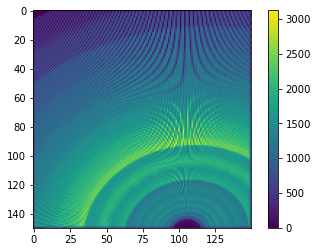

In [79]:
plt.imshow(rad_hist, vmin=0)
plt.colorbar()

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


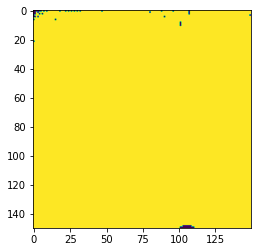

In [80]:
plt.imshow(rad_hist>0, vmin=0)

In [81]:
from scipy import stats

ref_hist = stats.binned_statistic_dd((rad_y_offset[mask].ravel(), rad_x_offset[mask].ravel()),
                                      rad_ref[mask].ravel(), statistic='mean',
                                      bins=(y_bins[::-1], x_bins),
                                      expand_binnumbers=True)[0][::-1]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


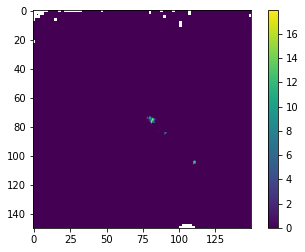

In [82]:
plt.imshow(ref_hist, vmin=0)
plt.colorbar()

In [83]:
np.sum(mask)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


119117745

In [86]:
np.sum(mask)/mask.size

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5440144173857

In [87]:
mask.shape

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(119520, 1832)

In [88]:
rad_time.shape

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(119520,)

In [95]:
rad_counts_da = xr.zeros_like(goes_ds.CMI_C13[:12]).compute()
rad_ref_da = xr.zeros_like(rad_counts_da)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
for i, t in enumerate(rad_counts_da.t):
    wh_t = np.logical_and(rad_time>=abi_dates[i], rad_time<abi_dates[i]+timedelta(minutes=5))
    rad_mask = np.logical_and(rad_alt[wh_t]>2500, rad_alt[wh_t]<15000)
    rad_counts_da[i] = np.histogram2d(rad_y_offset[wh_t][rad_mask], rad_x_offset[wh_t][rad_mask], 
                                      bins=(y_bins[::-1], x_bins))[0][::-1]
    rad_ref_da[i] = stats.binned_statistic_dd((rad_y_offset[wh_t][rad_mask], rad_x_offset[wh_t][rad_mask]),
                                      rad_ref[wh_t][rad_mask].ravel(), statistic='mean',
                                      bins=(y_bins[::-1], x_bins),
                                      expand_binnumbers=True)[0][::-1]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
def get_nexrad_hist(nexrad_time, nexrad_alt, nexrad_lat, nexrad_lon, nexrad_ref, 
                    goes_ds, start_time, end_time, min_alt=2500, max_alt=15000):
    
    wh_t = np.logical_and(nexrad_time>=start_time, nexrad_time<end_time)
    mask = np.logical_and(nexrad_alt[wh_t]>min_alt, nexrad_alt[wh_t]<max_alt)
    x,y = nexrad.map_nexrad_to_goes(nexrad_lat[wh_t][mask], nexrad_lon[wh_t][mask], 
                                    nexrad_alt[wh_t][mask], goes_ds)
    
    x_bins, y_bins = get_ds_bin_edges(goes_ds, ('x','y'))
    counts_hist = np.histogram2d(y, x, bins=(y_bins[::-1], x_bins))[0][::-1]
    ref_hist = stats.binned_statistic_dd((y, x), nexrad_ref[wh_t][mask], 
                                         statistic='mean',
                                         bins=(y_bins[::-1], x_bins),
                                         expand_binnumbers=True)[0][::-1]
    
    return counts_hist, ref_hist
    

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
get_nexrad_hist(rad_time, rad_alt, rad_lat, rad_lon, rad_ref, goes_ds, abi_dates[0], abi_dates[1])

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([[  0.,   0.,   0., ...,  35.,   0.,  35.],
        [  0.,   0.,   0., ...,  70.,  13.,  58.],
        [  0.,   0.,   0., ...,  71.,  68.,   5.],
        ...,
        [ 90., 187., 163., ...,  97., 137.,  76.],
        [ 59., 114., 122., ...,  80., 121.,  72.],
        [ 49.,  83.,  65., ...,  41.,  53.,  41.]]),
 array([[         nan,          nan,          nan, ..., -32.78571429,
                  nan, -32.78571429],
        [         nan,          nan,          nan, ..., -32.78571429,
         -32.73076923, -32.79310345],
        [         nan,          nan,          nan, ..., -32.78169014,
         -32.79411765, -32.8       ],
        ...,
        [-33.        , -33.        , -33.        , ..., -33.        ,
         -33.        , -33.        ],
        [-33.        , -33.        , -33.        , ..., -33.        ,
         -33.        , -33.        ],
        [-33.        , -33.        , -33.        , ..., -33.        ,
         -33.        , -33.        ]]))

In [104]:
rad_counts_da

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray 'CMI_C13' (t: 12, y: 150, x: 150)>
array([[[  0.,   0.,   0., ...,  35.,   0.,  35.],
        [  0.,   0.,   0., ...,  70.,  13.,  58.],
        [  0.,   0.,   0., ...,  71.,  68.,   5.],
        ...,
        [ 90., 187., 163., ...,  97., 137.,  76.],
        [ 59., 114., 122., ...,  80., 121.,  72.],
        [ 49.,  83.,  65., ...,  41.,  53.,  41.]],

       [[  0.,   0.,   0., ...,  36.,   0.,  26.],
        [  0.,   0.,   0., ...,  70.,  11.,  56.],
        [  0.,   0.,   0., ...,  68.,  50.,  21.],
        ...,
        [ 75., 148., 136., ..., 119., 157.,  82.],
        [ 49.,  99., 102., ..., 119., 155.,  82.],
        [ 40.,  65.,  57., ...,  65.,  68.,  52.]],

       [[  0.,   0.,   0., ...,  29.,   7.,  23.],
        [  0.,   0.,   0., ...,  61.,  17.,  43.],
        [  0.,   0.,   0., ...,  60.,  53.,   7.],
        ...,
...
        ...,
        [ 96., 194., 152., ...,  83., 156.,  92.],
        [ 59., 122., 152., ...,  84., 152.,  87.],
        [ 41.,  68.,  64., ...,  47.,  83.,  58.]],

       [[  0.,   0.,   0., ...,  34.,   8.,  19.],
        [  0.,   0.,   0., ...,  70.,  24.,  48.],
        [  0.,   0.,   0., ...,  57.,  55.,  16.],
        ...,
        [ 63., 133., 128., ..., 131., 150.,  77.],
        [ 48.,  93.,  94., ..., 117., 151.,  72.],
        [ 39.,  66.,  64., ...,  57.,  64.,  46.]],

       [[  0.,   0.,   0., ...,  35.,   0.,  25.],
        [  0.,   0.,   0., ...,  71.,  12.,  59.],
        [  0.,   0.,   0., ...,  70.,  54.,  17.],
        ...,
        [ 71., 154., 131., ..., 105., 142.,  79.],
        [ 57., 120., 130., ..., 107., 140.,  75.],
        [ 32.,  56.,  52., ...,  55.,  72.,  46.]]], dtype=float32)
Coordinates:
    x_image  float32 -0.03136
    y_image  float32 0.08624
  * x        (x) float32 -0.025732003 -0.025675997 ... -0.017444 -0.017388001
  * y        (y) float32 0.089012004 0.088956006 0.0889 ... 0.080724 0.080668
  * t        (t) datetime64[ns] 2018-06-19T16:03:43.239603968 ... 2018-06-19T...
Attributes:
    long_name:              ABI Cloud and Moisture Imagery brightness tempera...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF_C13

In [105]:
rad_ref_da

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray 'CMI_C13' (t: 12, y: 150, x: 150)>
array([[[       nan,        nan,        nan, ..., -32.785713,
                nan, -32.785713],
        [       nan,        nan,        nan, ..., -32.785713,
         -32.73077 , -32.793102],
        [       nan,        nan,        nan, ..., -32.78169 ,
         -32.794117, -32.8     ],
        ...,
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ],
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ],
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ]],

       [[       nan,        nan,        nan, ..., -32.72222 ,
                nan, -32.73077 ],
        [       nan,        nan,        nan, ..., -32.714287,
         -32.68182 , -32.732143],
        [       nan,        nan,        nan, ..., -32.713234,
         -32.75    , -32.642857],
...
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ],
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ],
        [-33.      , -33.      , -33.      , ..., -32.41228 ,
         -33.      , -33.      ]],

       [[       nan,        nan,        nan, ..., -32.714287,
                nan, -32.8     ],
        [       nan,        nan,        nan, ..., -32.71127 ,
         -32.791668, -32.70339 ],
        [       nan,        nan,        nan, ..., -32.714287,
         -32.787037, -32.5     ],
        ...,
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ],
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ],
        [-33.      , -33.      , -33.      , ..., -33.      ,
         -33.      , -33.      ]]], dtype=float32)
Coordinates:
    x_image  float32 -0.03136
    y_image  float32 0.08624
  * x        (x) float32 -0.025732003 -0.025675997 ... -0.017444 -0.017388001
  * y        (y) float32 0.089012004 0.088956006 0.0889 ... 0.080724 0.080668
  * t        (t) datetime64[ns] 2018-06-19T16:03:43.239603968 ... 2018-06-19T...
Attributes:
    long_name:              ABI Cloud and Moisture Imagery brightness tempera...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF_C13

In [106]:
%%capture
fig = plt.figure(dpi=150, figsize=(6,6))

img_shape=rad_ref_da[0].shape
img = plt.imshow(np.zeros(img_shape), vmin=0, vmax=45)
plt.xticks([])
plt.yticks([])
t1 = plt.title('Nexrad Radar', loc='left', size=8)
t2 = plt.title('', loc='right', size=8)

# init function: returns the plotting handles that will be modified
def init():
    img.set_data(np.zeros(img_shape))
    t2.set_text('')
    return img, t2

# animation function: modifies the data of the plot handles according to a frame index
def animate(i):
    img.set_data(rad_ref_da[i])
    t2.set_text(str(rad_ref_da.t[i].data.astype('datetime64[s]'))+' UTC')
    return img, t2

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=12, 
                               interval=20, blit=True)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
# Embed using ipython
from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
nexrad_files[0]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'./data/nexrad_l2/2018/06/19/KTBW/NWS_NEXRAD_NXL2DPBL_KTBW_20180619160000_20180619165959.tar'

In [120]:
radar_gates_1 = get_gates_from_tar(nexrad_files[1])

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
counts_0, refs_0 = get_nexrad_hist(*radar_gates_0, goes_ds, abi_dates[0], abi_dates[1])
counts_1, refs_1 = get_nexrad_hist(*radar_gates_1, goes_ds, abi_dates[0], abi_dates[1])

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


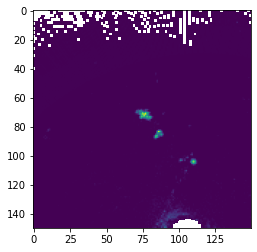

In [122]:
plt.imshow(refs_0)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


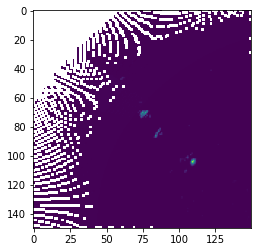

In [123]:
plt.imshow(refs_1)

In [148]:
combined_refs = np.nansum([refs_0*counts_0,refs_1*counts_1,refs_2*counts_2,refs_3*counts_3], 0)/np.nansum([counts_0,counts_1,counts_2,counts_3], 0)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-148-e7c4d036082a>:1: RuntimeWarning: invalid value encountered in true_divide
  combined_refs = np.nansum([refs_0*counts_0,refs_1*counts_1,refs_2*counts_2,refs_3*counts_3], 0)/np.nansum([counts_0,counts_1,counts_2,counts_3], 0)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


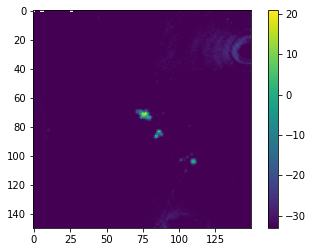

In [150]:
plt.imshow(combined_refs)
plt.colorbar()

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


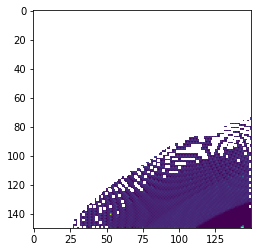

In [126]:
radar_gates_2 = get_gates_from_tar(nexrad_files[2])
counts_2, refs_2 = get_nexrad_hist(*radar_gates_2, goes_ds, abi_dates[0], abi_dates[1])
plt.imshow(refs_2)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


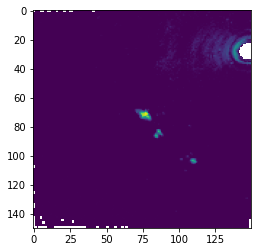

In [127]:
radar_gates_3 = get_gates_from_tar(nexrad_files[3])
counts_3, refs_3 = get_nexrad_hist(*radar_gates_3, goes_ds, abi_dates[0], abi_dates[1])
plt.imshow(refs_3)

In [139]:
def get_site_grids(nexrad_file, goes_ds, goes_dates):
    radar_gates = get_gates_from_tar(nexrad_file)
    temp_stack = [get_nexrad_hist(*radar_gates_3, goes_ds, dt, dt+timedelta(minutes=5)) for dt in goes_dates]
    return [np.stack(temp) for temp in zip(*temp_stack)]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
temp_stack = [get_nexrad_hist(*radar_gates_3, goes_ds, dt, dt+timedelta(minutes=5)) for dt in abi_dates[:12]]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
len(temp_stack)

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12

In [130]:
stack_count, stack_mean = [np.stack(temp) for temp in zip(*temp_stack)]

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [140]:
stack_count, stack_mean = get_site_grids(nexrad_files[3], goes_ds, abi_dates[:12])

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [141]:
stack_count.shape

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(12, 150, 150)

In [142]:
%%capture
fig = plt.figure(dpi=150, figsize=(6,6))

img_shape=stack_mean[0].shape
img = plt.imshow(np.zeros(img_shape), vmin=0, vmax=45)
plt.xticks([])
plt.yticks([])
t1 = plt.title('Nexrad Radar', loc='left', size=8)
t2 = plt.title('', loc='right', size=8)

# init function: returns the plotting handles that will be modified
def init():
    img.set_data(np.zeros(img_shape))
    t2.set_text('')
    return img, t2

# animation function: modifies the data of the plot handles according to a frame index
def animate(i):
    img.set_data(stack_mean[i])
    t2.set_text(str(rad_ref_da.t[i].data.astype('datetime64[s]'))+' UTC')
    return img, t2

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=12, 
                               interval=20, blit=True)


/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
# Embed using ipython
from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [154]:
np.all(np.isfinite(rad_ref.data))

/Users/jonesw/opt/anaconda3/envs/flow_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True